# Kuzushiji Classification with Support Vector Machines

In this notebook we are going to explore the use of Support Vector Machines (SVM) for image classification. We will use a variant of the famous MNIST dataset (the original is a dataset of handwritten digits). The version we are going to use is called Kuzushiji-MNIST or K-MNIST for short (https://github.com/rois-codh/kmnist) and is a dataset of traditional japanese handwritten kana.



The dataset labels are the following:

| Label | Hiragana Character | Romanji (Pronunciation) |
| :-: | :-: | :-: |
|   0   | お | o |
| 1 | き | ki |
| 2 | す | su |
| 3 | つ | tsu |
| 4 | な | na |
| 5 | は | ha |
| 6 | ま | ma |
| 7 | や | ya |
| 8 | れ | re |
| 9 | を | wo |

## TODO: Insert your surname, name and ID number

Student surname: Festa

Student name: Filippo
    
ID: 2029789

In [27]:
#load the required packages

%matplotlib inline  

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import sklearn.metrics as skm
from sklearn import metrics


bold = "\033[1m"
end = "\033[0m"

In [28]:
# helper function to load Kuzushiji-MNIST dataset

def load_mnist(path, kind = 'train'):
    
    import os
    import gzip
    import numpy as np
    
    labels_path = os.path.join(path, 'K%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path, 'K%s-images-idx3-ubyte.gz' % kind)
    
    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)
        
    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)
        
    return images, labels

In [29]:
#fix your ID ("numero di matricola") and the seed for random generator (as usual you can try different seeds)

ID = 2029789
np.random.seed(ID)

In [30]:
#load the K-MNIST dataset from the 'data' folder and let's normalize the features so that each value is in [0,1] 

X, y = load_mnist('data', kind='train')
# rescale the data
X, y = X / 255., y            # original pixel values are between 0 and 255

print("X shape:", X.shape)
print("X:\n", X)

print("\ny shape:", y.shape)
print("y:", y)

X shape: (60000, 784)
X:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

y shape: (60000,)
y: [8 7 0 ... 0 4 9]


Now split into training and test. Make sure that each label is present at least 10 times
in training. If it is not, then keep adding permutations to the initial data until this 
happens.

In [31]:
# Random permute the data and split into training and test taking the first 600
# data samples as training and 4000 samples as test

permutation = np.random.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]

m_training = 600
m_test = 4000

X_train, X_test = X[:m_training], X[m_training:m_training+m_test:]
y_train, y_test = y[:m_training], y[m_training:m_training+m_test:]

print("\nY_training:\n", y_train)
print("Shape of X_training set: " + str(X_train.shape))
print("Shape of Y_training set: " + str(y_train.shape))

print("\nY_test:\n", y_test)
print("Shape of X_test set: " + str(X_test.shape))
print("Shape of Y_test set: " + str(y_test.shape))


labels, freqs = np.unique(y_train, return_counts = True)
print("\nLabels in training dataset(y_train): ", labels)
print("Frequencies in training dataset(y_train): ", freqs)



Y_training:
 [3 7 7 7 4 2 0 0 4 0 7 8 6 8 4 7 2 5 7 9 5 7 5 7 1 8 1 3 1 6 8 5 3 6 5 8 4
 7 1 5 8 0 0 3 7 6 6 0 3 3 3 4 4 3 1 3 2 9 2 9 9 7 5 2 9 5 7 7 1 4 4 1 9 4
 0 0 2 4 8 7 8 2 0 3 4 5 5 5 7 2 2 1 2 4 7 3 0 0 1 3 5 6 7 2 5 5 8 7 1 5 3
 8 1 7 0 4 2 1 9 0 9 6 9 2 5 1 6 1 5 0 3 5 6 9 4 2 1 7 7 3 2 1 9 5 1 7 5 4
 8 7 2 7 8 9 4 6 3 3 0 7 9 1 0 9 4 9 1 5 2 7 5 5 2 5 9 8 0 2 4 8 2 8 3 3 8
 3 2 1 5 0 8 5 6 4 4 6 0 3 9 6 7 7 4 9 3 6 7 0 5 3 9 9 4 1 7 1 6 0 5 1 4 8
 0 5 7 9 6 4 5 1 9 9 0 4 0 6 3 1 6 2 2 8 5 7 3 6 9 3 5 9 9 4 6 1 7 8 9 1 7
 2 1 2 7 3 7 6 2 7 6 8 1 4 5 8 5 8 8 1 0 0 8 5 3 6 2 4 0 2 6 4 1 5 5 5 2 8
 3 0 1 4 8 1 9 7 3 1 8 8 6 1 4 6 2 1 1 3 7 0 4 4 3 2 0 7 0 2 1 0 1 6 5 6 0
 8 8 4 7 8 8 2 5 2 7 7 9 2 0 8 1 6 1 5 0 4 6 9 5 5 8 9 9 9 9 7 8 4 7 7 9 3
 5 3 0 5 6 9 8 4 0 1 9 4 8 7 2 5 5 3 4 9 1 8 5 4 0 4 2 4 4 8 3 2 7 7 3 0 8
 7 1 8 0 7 9 1 4 2 8 1 6 3 7 6 6 1 4 4 4 5 1 8 9 4 0 1 4 5 3 8 5 0 3 4 9 1
 5 7 0 7 2 3 7 5 0 9 1 4 2 3 8 2 0 5 8 3 0 9 5 7 8 4 4 4 0 7 7 8 0 5 8 3 7
 8 5 3 5 1 

In [32]:
#function for plotting a image and printing the corresponding label

def plot_input(X_matrix, labels, index):
    print("INPUT:")
    
    plt.imshow(
        X_matrix[index].reshape(28,28),
        cmap          = plt.cm.gray_r,
        interpolation = "nearest"
    )
    plt.show()
    
    print("LABEL: %i"%labels[index])
    return

INPUT:


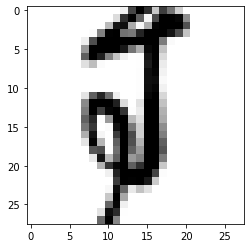

LABEL: 2



INPUT:


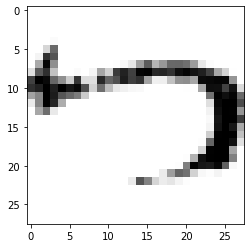

LABEL: 3



INPUT:


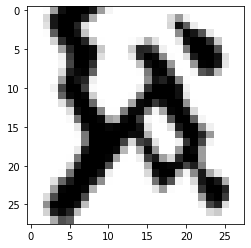

LABEL: 9



INPUT:


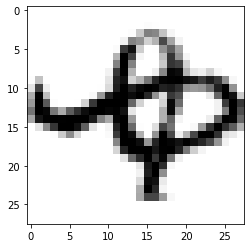

LABEL: 7


In [33]:
#let's try the plotting function
plot_input(X_train, y_train, 5)
print("\n\n")

plot_input(X_test, y_test, 50)
print("\n\n")

plot_input(X_test, y_test, 500)
print("\n\n")

plot_input(X_test, y_test, 700)

## TO DO 1
Use a SVM classifier with cross validation to pick a model. Use a 4-fold cross-validation. Let's start with a Linear kernel:

In [34]:
#import SVC
from sklearn.svm import SVC

#import for Cross-Validation
from sklearn.model_selection import GridSearchCV


# parameters for linear SVM
parameters = {'C': [0.01, 0.1, 1, 10]}


#train linear SVM
gdsea = GridSearchCV(SVC(kernel = 'linear'), parameters, cv = 4, refit = True, verbose = 3, n_jobs = -1) 
gdsea.fit(X_train, y_train) 

print (bold + 'RESULTS FOR LINEAR KERNEL' + end)
print(bold + "\n- Best parameters set found:" + end, gdsea.best_params_)

results_df = pd.DataFrame(gdsea.cv_results_)
print(bold + "\n- Score with best parameters:" + end, gdsea.best_score_, "+- %.5f" %results_df.std_test_score.loc[gdsea.best_index_])

print(bold + "\n\n- All scores on the grid:\n" + end)
results_df

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    6.4s finished


RESULTS FOR LINEAR KERNEL

- Best parameters set found: {'C': 0.01}

- Score with best parameters: 0.75 +- 0.01374


- All scores on the grid:



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.383531,0.013340,0.110188,0.005355,0.01,{'C': 0.01},0.76,0.766667,0.733333,0.74,0.750000,0.013744,1
1,0.380783,0.010788,0.100693,0.010980,0.1,{'C': 0.1},0.72,0.773333,0.733333,0.74,0.741667,0.019650,2
2,0.377286,0.001801,0.098942,0.002117,1,{'C': 1},0.72,0.773333,0.733333,0.74,0.741667,0.019650,2
3,0.369288,0.008316,0.101694,0.007755,10,{'C': 10},0.72,0.773333,0.733333,0.74,0.741667,0.019650,2


## TO DO 2
Pick a model for the Polynomial kernel with degree=2:

In [35]:
# parameters for poly with degree 2 kernel
parameters = {'C': [0.01, 0.1, 1], 'gamma':[0.01, 0.1, 1]}

#run SVM with poly of degree 2 kernel
degree = 2
gdsea = GridSearchCV(SVC(kernel = "poly", degree = degree), parameters, cv = 4, refit = True, verbose = 3, n_jobs = -1) 
gdsea.fit(X_train, y_train) 

print (bold + 'RESULTS FOR POLY DEGREE = 2 KERNEL' + end)

print(bold + "\n- Best parameters set found:" + end, gdsea.best_params_)

results_df = pd.DataFrame(gdsea.cv_results_)
print(bold + "\n- Score with best parameters:" + end, gdsea.best_score_, "+- %.5f" %results_df.std_test_score.loc[gdsea.best_index_])

print(bold + "\n\n- All scores on the grid:\n" + end)
results_df

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    7.4s finished


RESULTS FOR POLY DEGREE = 2 KERNEL

- Best parameters set found: {'C': 0.1, 'gamma': 0.1}

- Score with best parameters: 0.7683333333333334 +- 0.03069


- All scores on the grid:



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.597160,0.007692,0.125179,0.004021,0.01,0.01,"{'C': 0.01, 'gamma': 0.01}",0.126667,0.126667,0.126667,0.120000,0.125000,0.002887,9
1,0.504461,0.015966,0.106939,0.005097,0.01,0.1,"{'C': 0.01, 'gamma': 0.1}",0.746667,0.780000,0.760000,0.740000,0.756667,0.015275,6
2,0.567427,0.024980,0.129425,0.010821,0.01,1,"{'C': 0.01, 'gamma': 1}",0.740000,0.800000,0.766667,0.746667,0.763333,0.023333,2
3,0.812784,0.014299,0.181648,0.011159,0.1,0.01,"{'C': 0.1, 'gamma': 0.01}",0.460000,0.433333,0.446667,0.420000,0.440000,0.014907,8
4,0.657126,0.014984,0.144916,0.018591,0.1,0.1,"{'C': 0.1, 'gamma': 0.1}",0.740000,0.820000,0.760000,0.753333,0.768333,0.030687,1
5,0.647882,0.005307,0.156909,0.019222,0.1,1,"{'C': 0.1, 'gamma': 1}",0.740000,0.800000,0.766667,0.746667,0.763333,0.023333,2
6,0.684358,0.021510,0.157659,0.013489,1,0.01,"{'C': 1, 'gamma': 0.01}",0.746667,0.780000,0.760000,0.740000,0.756667,0.015275,6
7,0.742326,0.016762,0.144667,0.023647,1,0.1,"{'C': 1, 'gamma': 0.1}",0.740000,0.800000,0.766667,0.746667,0.763333,0.023333,2
8,0.728583,0.055588,0.184395,0.038248,1,1,"{'C': 1, 'gamma': 1}",0.740000,0.800000,0.766667,0.746667,0.763333,0.023333,2


## TO DO 3

Now let's try a higher degree for the polynomial kernel (e.g., 3rd degree).

In [36]:
# parameters for poly with higher degree kernel
parameters = {'C': [0.01, 0.1, 1],'gamma':[0.01, 0.1, 1]}

#run SVM with poly of higher degree kernel
degree = 3
gdsea = GridSearchCV(SVC(kernel = "poly", degree = degree), parameters, cv = 4, refit = True, verbose = 3, n_jobs = -1) 
gdsea.fit(X_train, y_train) 

print (bold + 'RESULTS FOR POLY DEGREE = ' + end, degree, bold + ' KERNEL' + end)

print(bold + "\n- Best parameters set found:" + end, gdsea.best_params_)

results_df = pd.DataFrame(gdsea.cv_results_)
print(bold + "\n- Score with best parameters:" + end, gdsea.best_score_, "+- %.5f" %results_df.std_test_score.loc[gdsea.best_index_])

print(bold + "\n- All scores on the grid:\n" + end)
results_df

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    8.0s finished


RESULTS FOR POLY DEGREE =  3  KERNEL

- Best parameters set found: {'C': 0.01, 'gamma': 0.1}

- Score with best parameters: 0.7283333333333334 +- 0.01908

- All scores on the grid:



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.973445,0.037456,0.191890,0.007838,0.01,0.01,"{'C': 0.01, 'gamma': 0.01}",0.126667,0.126667,0.126667,0.120000,0.125000,0.002887,9
1,0.784053,0.016685,0.135922,0.008272,0.01,0.1,"{'C': 0.01, 'gamma': 0.1}",0.726667,0.760000,0.713333,0.713333,0.728333,0.019076,1
2,0.748574,0.014224,0.136422,0.015246,0.01,1,"{'C': 0.01, 'gamma': 1}",0.680000,0.706667,0.686667,0.653333,0.681667,0.019076,3
3,0.690854,0.023271,0.259602,0.027219,0.1,0.01,"{'C': 0.1, 'gamma': 0.01}",0.433333,0.493333,0.380000,0.406667,0.428333,0.041999,8
4,0.831525,0.067939,0.142167,0.036819,0.1,0.1,"{'C': 0.1, 'gamma': 0.1}",0.666667,0.713333,0.686667,0.646667,0.678333,0.024664,7
5,0.811287,0.020192,0.109437,0.005405,0.1,1,"{'C': 0.1, 'gamma': 1}",0.680000,0.706667,0.686667,0.653333,0.681667,0.019076,3
6,0.498463,0.028420,0.105939,0.017063,1,0.01,"{'C': 1, 'gamma': 0.01}",0.720000,0.740000,0.726667,0.700000,0.721667,0.014434,2
7,0.580918,0.014052,0.110437,0.009754,1,0.1,"{'C': 1, 'gamma': 0.1}",0.680000,0.706667,0.686667,0.653333,0.681667,0.019076,3
8,0.676613,0.026128,0.097945,0.007838,1,1,"{'C': 1, 'gamma': 1}",0.680000,0.706667,0.686667,0.653333,0.681667,0.019076,3


## TO DO 4
Pick a model for the Radial Basis Function kernel:

In [37]:
# parameters for rbf SVM
parameters = {'C': [0.1, 1, 10, 100], 'gamma':[0.001, 0.01, 0.1,1]}

#run SVM with rbf kernel
gdsea = GridSearchCV(SVC(kernel = "rbf"), parameters, cv = 4, refit = True, verbose = 3, n_jobs = -1) 
gdsea.fit(X_train, y_train) 

print (bold + 'RESULTS FOR rbf KERNEL' + end)

print(bold + "\n- Best parameters set found:" + end, gdsea.best_params_)

results_df = pd.DataFrame(gdsea.cv_results_)
print(bold + "\n- Score with best parameters:" + end, gdsea.best_score_, "+- %.5f" %results_df.std_test_score.loc[gdsea.best_index_])

print(bold + "\n\n- All scores on the grid:\n" + end)
results_df

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   11.0s finished


RESULTS FOR rbf KERNEL

- Best parameters set found: {'C': 10, 'gamma': 0.01}

- Score with best parameters: 0.79 +- 0.03037


- All scores on the grid:



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.545641,0.003638,0.122202,0.004884,0.1,0.001,"{'C': 0.1, 'gamma': 0.001}",0.126667,0.126667,0.126667,0.120000,0.125000,0.002887,11
1,0.528217,0.008449,0.121294,0.008449,0.1,0.01,"{'C': 0.1, 'gamma': 0.01}",0.220000,0.166667,0.246667,0.200000,0.208333,0.029202,7
2,0.555247,0.015625,0.121086,0.006763,0.1,0.1,"{'C': 0.1, 'gamma': 0.1}",0.126667,0.126667,0.126667,0.120000,0.125000,0.002887,11
3,0.540593,0.007812,0.126633,0.000002,0.1,1,"{'C': 0.1, 'gamma': 1}",0.126667,0.126667,0.126667,0.120000,0.125000,0.002887,11
4,0.456921,0.011048,0.121086,0.006764,1,0.001,"{'C': 1, 'gamma': 0.001}",0.600000,0.660000,0.640000,0.606667,0.626667,0.024495,6
5,0.509784,0.010255,0.121368,0.005699,1,0.01,"{'C': 1, 'gamma': 0.01}",0.760000,0.793333,0.773333,0.766667,0.773333,0.012472,3
6,0.541906,0.008317,0.141156,0.006737,1,0.1,"{'C': 1, 'gamma': 0.1}",0.160000,0.153333,0.160000,0.146667,0.155000,0.005528,10
7,0.548124,0.006393,0.136711,0.006764,1,1,"{'C': 1, 'gamma': 1}",0.126667,0.126667,0.126667,0.120000,0.125000,0.002887,11
8,0.361304,0.013386,0.126602,0.011318,10,0.001,"{'C': 10, 'gamma': 0.001}",0.766667,0.786667,0.746667,0.753333,0.763333,0.015275,5
9,0.543899,0.012942,0.139227,0.009248,10,0.01,"{'C': 10, 'gamma': 0.01}",0.760000,0.840000,0.786667,0.773333,0.790000,0.030368,1


## QUESTION 1
What do you observe when using linear, polynomial and RBF kernels on this dataset ?

We can observe different mean test scores (mts) depending on the best hyperparameters chosen for the given classifier and on the corresponding kernel, in particular I got (for the best hyperparameters of each classifier):
- linear kernel mts: $0.75 \pm 0.01$ 
- polynomial degree 2 kernel mts: $0.77\pm0.03$   
- polynomial degree 3 kernel mts: $0.73\pm0.02$  
- radial basis function kernel mts: $0.79\pm0.03$  

In this case we can notice that our given classes aren't best classified with a linear predictor, that's a remark on the non-linearity of the dataset. $\newline$ The best SVM kernel is the Radial Basis Function one (with $C=1$ and $\gamma=0.01$), this is likely due to the fact that this type of kernel evaluate the similarity between samples through the computing of their distances, in our case exploiting a gaussian distribution with a quite large standard deviation, so then it generalise better the classes' distribution.

## TO DO 5
Report here the best SVM kernel and parameters

In [38]:
# get training and test error for the best SVM model from CV

best_SVM = {'C': 10, 'gamma': 0.01}                                         # USE YOUR OPTIMAL PARAMETERS
svm = SVC(kernel = "rbf", C = best_SVM["C"], gamma = best_SVM["gamma"])

svm.fit(X_train, y_train)

training_error = 1 - svm.score(X_train, y_train)                            # (error is 1 - svm.score)
test_error = 1 - svm.score(X_test, y_test)


print ("Best SVM training error: %f" % training_error)
print ("Best SVM test error: %f" % test_error)

Best SVM training error: 0.000000
Best SVM test error: 0.177500


## TO DO 6

Analyze how the gamma parameter (inversely proportional to standard deviation of Gaussian Kernel) impact the performances of the classifier

In [39]:
#Test with different values of gamma

# Set gamma values
gamma_values = np.logspace(-5,2,8)

print(gamma_values)

[  0.     0.     0.     0.01   0.1    1.    10.   100.  ]


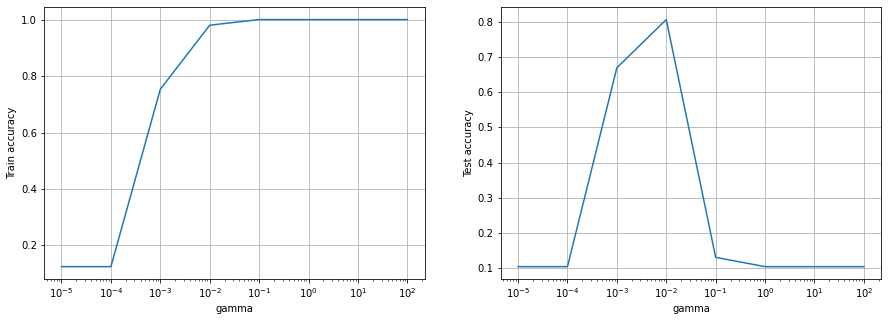

In [40]:
# Try the SVM with the previously set values of gamma
# use rbf kernel and C=1

train_acc_list, test_acc_list = [], []

for gamma in gamma_values:
    svm = SVC(kernel = "rbf", C = 1, gamma = gamma)
    svm.fit(X_train, y_train)
    
    train_acc_list.append(svm.score(X_train, y_train))
    test_acc_list.append(svm.score(X_test, y_test))


# ADD YOUR CODE TO TRAIN THE SVM MULTIPLE TIMES WITH THE DIFFERENT VALUES OF GAMMA
# PLACE THE TRAIN AND TEST ACCURACY FOR EACH TEST IN THE TRAIN AND TEST ACCURACY LISTS

# Plot
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(gamma_values, train_acc_list)
ax[0].set_xscale('log')
ax[0].set_xlabel('gamma')
ax[0].set_ylabel('Train accuracy')
ax[0].grid(True)

ax[1].plot(gamma_values, test_acc_list)
ax[1].set_xscale('log')
ax[1].set_xlabel('gamma')
ax[1].set_ylabel('Test accuracy')
ax[1].grid(True)


plt.show()

## QUESTION 2
How do the train and test error change when changing gamma ? Which is the best value of gamma ? 
Connect your answers to the discussion about the overfitting issue.

As we can see in the plots above the training accuracy increases as the gamma parameter increase getting the unitary value as it reaches the value $\gamma=10^{-1}$. Instead for what concerns the test accuracy we get a sort of broken peaked trend with the maximum at $\gamma=0.01$.

$\newline$We can recognise from the plots that the best value of gamma is $\gamma=10^{-2}=0.01$, which is consistent with what we have obtained in the tuning of hyperparamters. 

$\newline$ In this two plots we can observe how our predictors overfits the data increasing gamma above the $\gamma=0.01$ value: all the train samples are correctly classified while the test's one starts to be more and more misclassified. In practise the radial basis function kernel is going through our train dataset trying to learn it employing a gaussian with a narrower standard deviation as gamma increases: the result it's the overfitting and the extreme specialization of the classifier on the training data.

## More data
Now let's do the same but using more data points for training.


Choose a new number of data points.

In [41]:
X = X[permutation]
y = y[permutation]

m_training = 2000                                 # TODO number of data points, adjust depending on the capabilities of your PC

X_train, X_test = X[:m_training], X[m_training:]
y_train, y_test = y[:m_training], y[m_training:]

print("\nY_training:\n", y_train)
print("Shape of X_training set: " + str(X_train.shape))
print("Shape of Y_training set: " + str(y_train.shape))

print("\nY_test:\n", y_test)
print("Shape of X_test set: " + str(X_test.shape))
print("Shape of Y_test set: " + str(y_test.shape))

labels, freqs = np.unique(y_train, return_counts=True)
print("\nLabels in training dataset: ", labels)
print("Frequencies in training dataset: ", freqs)


Y_training:
 [1 6 6 ... 6 9 4]
Shape of X_training set: (2000, 784)
Shape of Y_training set: (2000,)

Y_test:
 [2 6 6 ... 9 6 3]
Shape of X_test set: (58000, 784)
Shape of Y_test set: (58000,)

Labels in training dataset:  [0 1 2 3 4 5 6 7 8 9]
Frequencies in training dataset:  [208 185 200 191 187 208 194 225 191 211]


## TO DO 7

Let's try to use SVM with parameters obtained from the best model for $m_{training} =  2000$. Since it may take a long time to run, you can decide to just let it run for some time and stop it if it does not complete. If you decide to do this, report it in the cell below.

In [42]:
# get training and test error for the best SVM model from CV

best_SVM = {'C': 10, 'gamma': 0.01}                                         
svm = SVC(kernel = "rbf", C = best_SVM["C"], gamma = best_SVM["gamma"])

svm.fit(X_train, y_train)

training_error = 1 - svm.score(X_train, y_train)                          
test_error = 1 - svm.score(X_test, y_test)

print ("Best SVM training error: %f" % training_error)
print ("Best SVM test error: %f" % test_error)

Best SVM training error: 0.000000
Best SVM test error: 0.115690


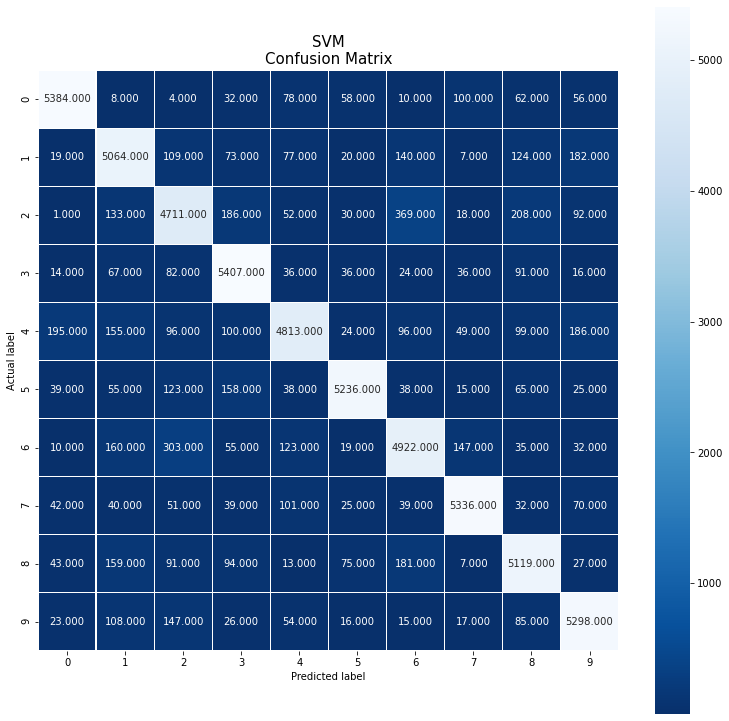

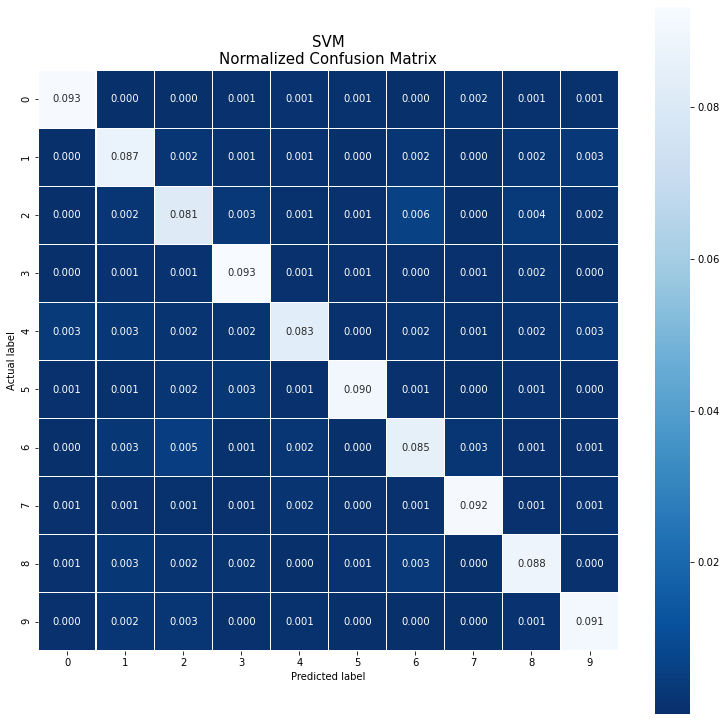

In [43]:
SVM_prediction = svm.predict(X_test)
cm = metrics.confusion_matrix(y_test, SVM_prediction)

plt.figure(figsize = (13,13))
sns.heatmap(cm, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('SVM\nConfusion Matrix', size = 15);
plt.show()


cmn = metrics.confusion_matrix(y_test, SVM_prediction, normalize='all')
plt.figure(figsize = (13,13))
sns.heatmap(cmn, annot = True, fmt='.3f', linewidths = .5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('SVM\nNormalized Confusion Matrix', size = 15);
plt.show()


Just for comparison, let's also use logistic regression 

## TO DO 8 Try first without regularization (use a very large large C)¶

In [44]:
from sklearn import linear_model

logisticRegr = linear_model.LogisticRegression(C = 1e5,  max_iter = 200)
fit = logisticRegr.fit(X_train, y_train)

training_error = 1 - logisticRegr.score(X_train, y_train)
test_error = 1 - logisticRegr.score(X_test, y_test)

print ("Best logistic regression training error: %f" % training_error)
print ("Best logistic regression test error: %f" % test_error)

Best logistic regression training error: 0.000000
Best logistic regression test error: 0.291190


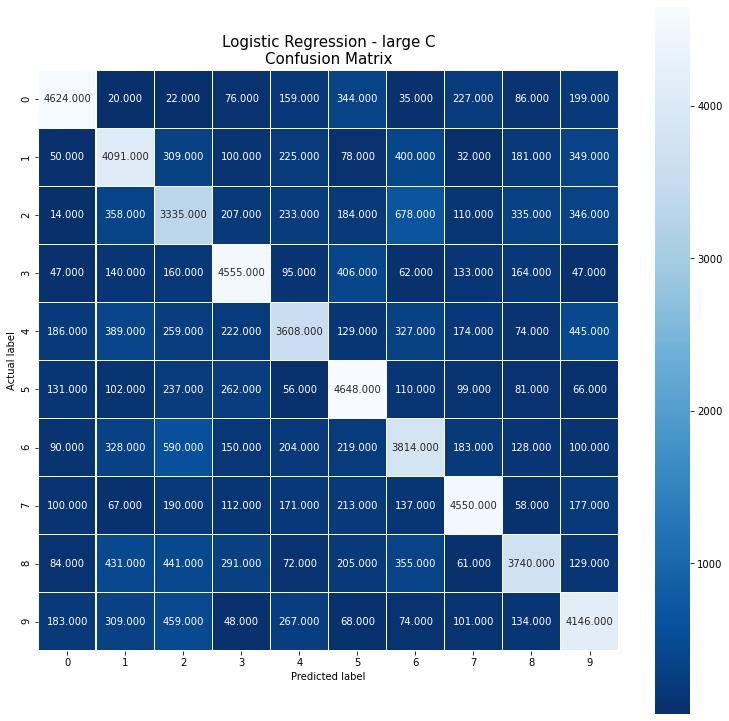

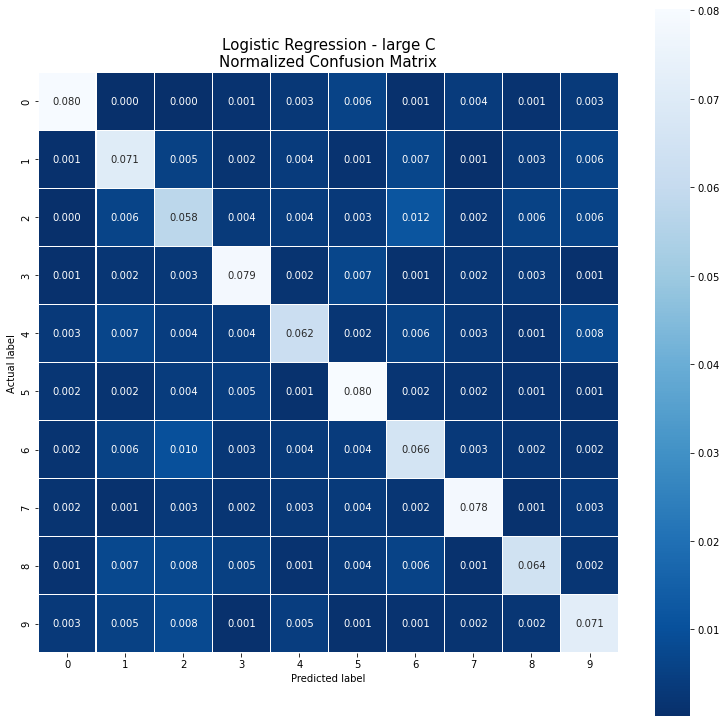

In [45]:
prediction = logisticRegr.predict(X_test)
cm = metrics.confusion_matrix(y_test, prediction)

plt.figure(figsize = (13,13))
sns.heatmap(cm, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Logistic Regression - large C\nConfusion Matrix', size = 15);
plt.show()


cmn = metrics.confusion_matrix(y_test, prediction, normalize='all')
plt.figure(figsize = (13,13))
sns.heatmap(cmn, annot = True, fmt='.3f', linewidths = .5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Logistic Regression - large C\nNormalized Confusion Matrix', size = 15);
plt.show()

## TO DO 9 Try  with regularization (use C=1)¶

In [46]:
logisticRegr = linear_model.LogisticRegression(C = 1,  max_iter = 400)
fit = logisticRegr.fit(X_train, y_train)

training_error = 1 - logisticRegr.score(X_train, y_train)
test_error = 1 - logisticRegr.score(X_test, y_test)

print ("Best regularized logistic regression training error: %f" % training_error)
print ("Best regularized logistic regression test error: %f" % test_error)

Best regularized logistic regression training error: 0.001500
Best regularized logistic regression test error: 0.258500


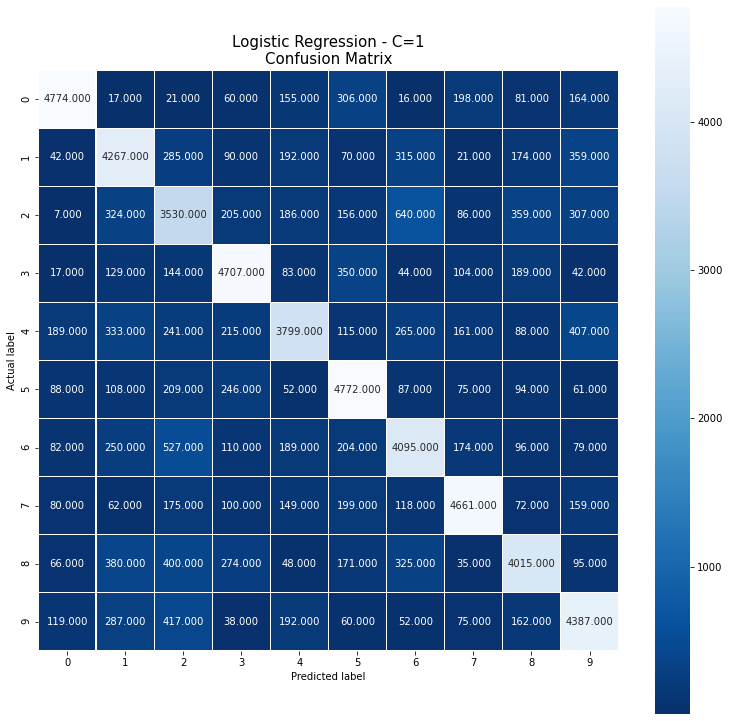

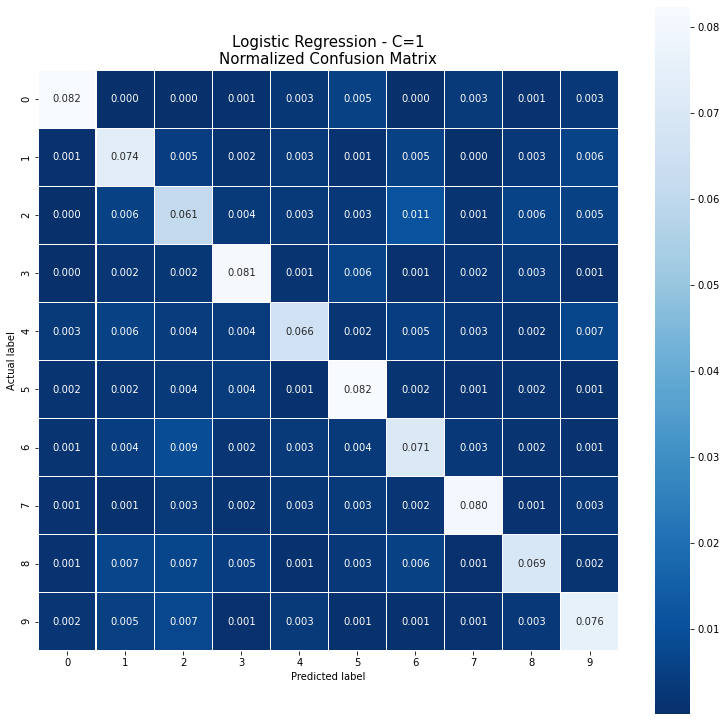

In [47]:
LR_prediction = logisticRegr.predict(X_test)
cm = metrics.confusion_matrix(y_test, LR_prediction)

plt.figure(figsize = (13,13))
sns.heatmap(cm, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Logistic Regression - C=1\nConfusion Matrix', size = 15);
plt.show()


cmn = metrics.confusion_matrix(y_test, LR_prediction, normalize='all')
plt.figure(figsize = (13,13))
sns.heatmap(cmn, annot = True, fmt='.3f', linewidths = .5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Logistic Regression - C=1\nNormalized Confusion Matrix', size = 15);
plt.show()

## QUESTION 3
- Compare and discuss - the results from SVM with $m=600$ and with $m=2000$ training data points

$\newline$ We get a $0.178$ and a $0.116$ test error respectively for $m=600$ and $m=2000$ training data points, while a zero training error in either cases. We were expecting this result: in general increase the traing dataset should reduce spurious correlations and improve the performance of the learner. Let's mark that this is not always the case, it depends on the statistical relevance and representativeness of the choosen training data points.

- Compare and discuss - the results of SVM and of Logistic Regression
$\newline$ Concerning the logistic regression's result we get a $0.291$ and a $0.259$ test error while a $0$ and a $0.002$ training error, respectively without and with the chosen regularization. As we introduced the regularization ($C=1$) the test error decreases, so it discourages learning a more complex model and avoid the risk of overfitting.

$\newline$ We can notice that the support vector machine implementation get better accuracies, either on training and test, than the logistic regression. 
Logistic regression focuses on maximizing the probability of the data. The farther the data lies on the correct side from the separating hyperplane, the better this method works.
Instead a support vector machine tries to find the separating hyperplane that maximizes the distance of the closest points to the margin, so if a point is not a support vector it doesn’t really matter. So the support vector machine doesn’t penalize samples for which the correct decision is made with sufficient confidence and this may be a good generalization also in our particular case.


## TO DO 10
Plot an item of clothing that is missclassified by logistic regression and correctly classified by SVM.

       Actual  LR_Prediction  SVM_Prediction
0           2              6               6
1           6              7               6
2           6              0               7
3           8              8               8
4           2              3               8
...       ...            ...             ...
57995       9              9               9
57996       0              6               0
57997       9              9               9
57998       6              6               6
57999       3              3               3

[58000 rows x 3 columns]


Dataframe of the items that are  missclassified by logistic regression and correctly classified by SVM:
        Actual  LR_Prediction  SVM_Prediction
1           6              7               6
13          5              4               5
16          7              6               7
22          9              4               9
50          2              9               2
...       ...            ...             ...
57954       

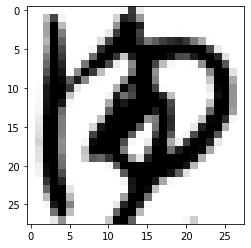

LABEL: 6
Linear Regression prediction: 7
SVM prediction: 6





In [48]:
# LR_prediction = logisticRegr.predict(X_test)
# SVM_prediction = svm.predict(X_test)

df = pd.DataFrame({'Actual': y_test, 'LR_Prediction': LR_prediction, 'SVM_Prediction': SVM_prediction})
print(df)

filtered_df = df[(df['LR_Prediction']!=df['Actual']) & (df['SVM_Prediction']==df['Actual'])]
print("\n\nDataframe of the items that are  missclassified by logistic regression and correctly classified by SVM:\n", 
      filtered_df)

# Let's plot one of this dataframe's item 
indexes = filtered_df.index.tolist()

print("\n\n")
plot_input(X_test, y_test, indexes[0])
print("Linear Regression prediction:", filtered_df.LR_Prediction.iloc[0])
print("SVM prediction:", filtered_df.SVM_Prediction.iloc[0])
print("\n\n")

INPUT:


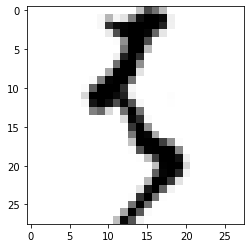

LABEL: 5
Linear Regression prediction: 4
SVM prediction: 5



INPUT:


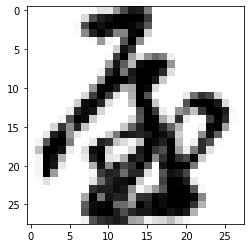

LABEL: 7
Linear Regression prediction: 6
SVM prediction: 7



INPUT:


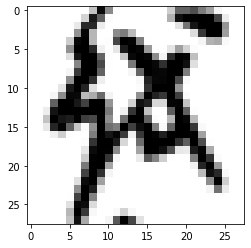

LABEL: 9
Linear Regression prediction: 4
SVM prediction: 9



INPUT:


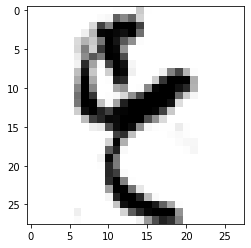

LABEL: 2
Linear Regression prediction: 9
SVM prediction: 2



INPUT:


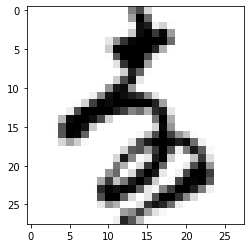

LABEL: 4
Linear Regression prediction: 2
SVM prediction: 4



INPUT:


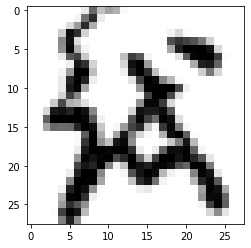

LABEL: 9
Linear Regression prediction: 2
SVM prediction: 9





In [49]:
# Let's plot a part (the beginning) of this dataframe's item 

for i in indexes[1:7]:
    plot_input(X_test, y_test, i)
    print("Linear Regression prediction:", filtered_df.LR_Prediction.loc[i])
    print("SVM prediction:", filtered_df.SVM_Prediction.loc[i])
    print("\n\n")

## TO DO 11
Plot the confusion matrix for the SVM classifier and for logistic regression.
The confusion matrix has one column for each predicted label and one row for each true label. 
It shows for each class in the corresponding row how many samples belonging to that class gets each possible output label.
Notice that the diagonal contains the correctly classified samples, while the other cells correspond to errors.
You can obtain it with the sklearn.metrics.confusion_matrix function (see the documentation).
Try also to normalize the confusion matrix by the number of samples in each class in order to measure the accuracy on each single class.


In [50]:
np.set_printoptions(precision=2, suppress=True)         # for better aligned printing of confusion matrix use floatmode='fixed'

u, counts = np.unique(y_test, return_counts = True)
print("Labels and frequencies in test set: ", counts)

confusion_SVM = metrics.confusion_matrix(y_test, SVM_prediction)
print("\n\n Confusion matrix SVM  \n \n", confusion_SVM)
print("\n Confusion matrix SVM (normalized)   \n \n", confusion_SVM /counts[:,None] )

confusion_LR = metrics.confusion_matrix(y_test, LR_prediction)
print("\n\n Confusion matrix LR  \n \n", confusion_LR)
print("\n Confusion matrix LR (normalized)   \n \n", confusion_LR /counts[:,None] )

Labels and frequencies in test set:  [5792 5815 5800 5809 5813 5792 5806 5775 5809 5789]


 Confusion matrix SVM  
 
 [[5384    8    4   32   78   58   10  100   62   56]
 [  19 5064  109   73   77   20  140    7  124  182]
 [   1  133 4711  186   52   30  369   18  208   92]
 [  14   67   82 5407   36   36   24   36   91   16]
 [ 195  155   96  100 4813   24   96   49   99  186]
 [  39   55  123  158   38 5236   38   15   65   25]
 [  10  160  303   55  123   19 4922  147   35   32]
 [  42   40   51   39  101   25   39 5336   32   70]
 [  43  159   91   94   13   75  181    7 5119   27]
 [  23  108  147   26   54   16   15   17   85 5298]]

 Confusion matrix SVM (normalized)   
 
 [[0.93 0.   0.   0.01 0.01 0.01 0.   0.02 0.01 0.01]
 [0.   0.87 0.02 0.01 0.01 0.   0.02 0.   0.02 0.03]
 [0.   0.02 0.81 0.03 0.01 0.01 0.06 0.   0.04 0.02]
 [0.   0.01 0.01 0.93 0.01 0.01 0.   0.01 0.02 0.  ]
 [0.03 0.03 0.02 0.02 0.83 0.   0.02 0.01 0.02 0.03]
 [0.01 0.01 0.02 0.03 0.01 0.9  0.01 0.   0.

In [51]:
# ADD CODE TO NORMALIZE CONFUSION MATRIX AND PRINT THE NORMALIZED MATRIX 
#  (=> See above for the normalized confusion matrix with seaborn!)


Norm_confusion_SVM = metrics.confusion_matrix(y_test, SVM_prediction, normalize='all')
print("\n\n Confusion matrix SVM  (normalized)\n \n", Norm_confusion_SVM)

Norm_confusion_LR = metrics.confusion_matrix(y_test, LR_prediction,  normalize='all')
print("\n\n Confusion matrix LR (normalized) \n \n", Norm_confusion_LR)




 Confusion matrix SVM  (normalized)
 
 [[0.09 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.09 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.08 0.   0.   0.   0.01 0.   0.   0.  ]
 [0.   0.   0.   0.09 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.08 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.09 0.   0.   0.   0.  ]
 [0.   0.   0.01 0.   0.   0.   0.08 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.09 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.09 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.09]]


 Confusion matrix LR (normalized) 
 
 [[0.08 0.   0.   0.   0.   0.01 0.   0.   0.   0.  ]
 [0.   0.07 0.   0.   0.   0.   0.01 0.   0.   0.01]
 [0.   0.01 0.06 0.   0.   0.   0.01 0.   0.01 0.01]
 [0.   0.   0.   0.08 0.   0.01 0.   0.   0.   0.  ]
 [0.   0.01 0.   0.   0.07 0.   0.   0.   0.   0.01]
 [0.   0.   0.   0.   0.   0.08 0.   0.   0.   0.  ]
 [0.   0.   0.01 0.   0.   0.   0.07 0.   0.   0.  ]
 [0.   0.   0.   

## QUESTION 4
Have a look at the confusion matrices and comment on the obtained accuracies. Why some classes have lower accuracies and others an higher one ? Make some guesses on the possible causes.


Looking at Confusion Matrix, that is a technique for summarizing the performance of a classification algorithm, we are driven to the same conclusion as before: our support vector machine is a better classifier then the logistic regression. In facts great part of the dataset is printed out of the diagonal of the logistic regression confusion matrix (best view for the comparison on the normalized one).
$\newline$ Furthermore we can notice that index two and index six classes are often mistaken one for the other by the classifier on the support vector machine's confusion matrix, this is likely due to the resemblance of this two traditional japanese handwritten kana that can be easily misinterpreted.
 
 